# 数据读入模块

In [28]:
import pandas as pd



train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [29]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [30]:
train_data['is_judicial']=[0 if pd.isna(i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial']=[0 if pd.isna(i) else 1 for i in test_data['judicial_reason']]

In [31]:
train_data['nan_num']=(train_data==0).astype(int).sum(axis=1)
test_data['nan_num']=(test_data==0).astype(int).sum(axis=1)

In [32]:
import pandas as pd
temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")


def chuli_loan(df, colname, ways):
    cust_id = list(set(df['cust_id']))
    res_df = pd.DataFrame({'cust_id': cust_id})
    temp_train = pd.read_csv('./data/df_train.csv')
    temp_test = pd.read_csv('./data/df_test.csv')

    ways_1 = []
    temp = list(temp_test.columns)
    global train_data,test_data

    for i in ways:
        if (colname+'_'+i) not in temp:
            ways_1.append(i)
            res_df[colname+'_'+i] = None
        else:
            print(colname+'_'+i+'已存在')
            train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                  how="left", suffixes=("", "_y"))
            test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                 how="left", suffixes=("", "_y"))
    ways = ways_1
    if len(ways) == 0:
        return res_df
    for i in cust_id:
        cust_df = df[df['cust_id'] == i]
        if 'mean' in ways:
            x = cust_df[colname].mean()
            res_df.loc[i, colname+'_mean'] = x
        if 'sum' in ways:
            x = cust_df[colname].sum()
            res_df.loc[i, colname+'_sum'] = x
        if 'count' in ways:
            x = cust_df[colname].count()
            res_df.loc[i, colname+'_count'] = x
    return res_df


for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
    df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count'))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'date_3', ('count',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_10', ('mean',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_11', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_12', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))


loan1_1_mean已存在
loan1_1_sum已存在
loan1_1_count已存在
loan1_3_mean已存在
loan1_3_sum已存在
loan1_3_count已存在
loan1_7_mean已存在
loan1_7_sum已存在
loan1_7_count已存在
loan1_9_mean已存在
loan1_9_sum已存在
loan1_9_count已存在
date_3_count已存在
loan1_10_mean已存在
loan1_11_sum已存在
loan1_12_sum已存在


## 处理NAN

In [33]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [34]:
df_train = delnan(train_data)
df_test = delnan(test_data)

## 处理-99

In [35]:
df_train.replace(-99,-1,inplace=True)
df_test.replace(-99,-1,inplace=True)

In [36]:
df_train.to_csv('./data/df_train.csv')
df_test.to_csv('./data/df_test.csv')

## 主成分分析（效果不好）

In [37]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]

## 处理分类变量

In [38]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",]

## 转化为one-hot编码（不宜采用）

In [39]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """

' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [40]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [41]:
df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [42]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col=[i for i in full_col_name if "judicial" in i]
loan_pca_col=[i for i in full_col_name if "loan_pca" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """

' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## rank化

In [43]:
def rank(rank_col):
    global df_train,df_test
    df1=df_train[['cust_id']+rank_col]
    df2=df_test[['cust_id']+rank_col]
    df=pd.concat([df1,df2],axis=0,ignore_index=True)
    for i in rank_col:
        df[i]=np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                     how="left", suffixes=("", "_y"))
a=['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b=['_sum','_mean']
c=[]
for i in a:
    for j in b:
        c.append(i+j)
#rank(c)

## 设置哪些x作为模型自变量输入

In [44]:
x_col = basic_col+['is_judicial']+loan_col+['date_3_count']+query_col

In [45]:
# df_train.drop(columns=drop_col)

# 训练模型

## 超参数

In [46]:
N = 100
num_round = 100
local_test_size=3000

max_depth = [3, 4, 5,6,7,8]
eta = [0.1,0.06]
colsample_bytree = [0.8,0.7, 0.6]
scale_pos_weight = [1, 3, 6, 10,20, 30]
test_size=[0.3,0.2,0.4,0.5,0.6,0.7]
subsample=[0.8,0.7,0.6,0.5,0.4]
par_lambda=[1,1.5,2,3]
alpha=[0,0.2,0.4,0.6,0.8]
min_child_weight=[1,2,3,4,5]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [47]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0
important_x_seq=[]

num_seq=list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test=df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test=df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest=xgb.DMatrix(X_local_test,label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        #'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample':random.choice(subsample),
        'alpha':random.choice(alpha),
        'lambda':random.choice(par_lambda),
        'min_child_weight':random.choice(min_child_weight),
        #'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        #"enable_enable_categorical":True,
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=5, verbose_eval=False)
    
    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])


    temp_dict={"test_auc":loss,"train_auc":train_loss,'local_test_auc':local_test_loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    
    if False:
        pic=xgb.plot_importance(bst,max_num_features=50)
        temp=pic.get_ymajorticklabels()
        important_x=[str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq+=important_x

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")

1:0.670733191251268
2:0.7003329015628498
3:0.6763307364797536
4:0.614447277279747
5:0.6422506117299654
6:0.6503381035044864
7:0.6948082284680883
8:0.6339496673465141
9:0.6837631330961055
10:0.6812747152624485
11:0.6659530087192921
12:0.6394635922001651
13:0.623499323130546
14:0.6839730790622487
15:0.6553454636389465
16:0.6735631522406385
17:0.6534691896741236
18:0.6305339925095622
19:0.6819877754820937
20:0.6328196608615949
21:0.7125960568515807
22:0.6685874564533274
23:0.6321104140307505
24:0.6804612538821413
25:0.6244958253866
26:0.6648425070823316
27:0.6588939221362317
28:0.632743901903415
29:0.6848948219166935
30:0.6133816885814576
31:0.651447865876702
32:0.6469684976625585
33:0.609098981123987
34:0.6461747204114586
35:0.6510842448666283
36:0.6662409316533028
37:0.6809880548944237
38:0.668423443503692
39:0.6875044438267974
40:0.6606135172413793
41:0.6693896058597838
42:0.668020714012982
43:0.6691866107410149
44:0.6881580879716119
45:0.6156659152703865
46:0.7008815674721022
47:0.677

In [48]:
info_df

,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,tree_method,gpu_id
0,0.670733,0.971586,0.718849,0.7,5,0.06,0.8,binary:logistic,6,auc,0.5,0.8,2.0,4,gpu_hist,0
1,0.700333,0.816141,0.727006,0.5,3,0.06,0.6,binary:logistic,10,auc,0.4,0.4,1.5,1,gpu_hist,0
2,0.676331,0.833874,0.717482,0.4,4,0.06,0.7,binary:logistic,3,auc,0.5,0.4,1.5,1,gpu_hist,0
3,0.614447,0.952145,0.686991,0.6,6,0.10,0.7,binary:logistic,3,auc,0.6,0.0,2.0,2,gpu_hist,0
4,0.642251,0.999660,0.698653,0.5,8,0.06,0.8,binary:logistic,10,auc,0.8,0.2,1.0,4,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.595599,0.885161,0.707489,0.2,8,0.06,0.6,binary:logistic,3,auc,0.7,0.6,2.0,3,gpu_hist,0
96,0.649512,0.993860,0.719161,0.7,8,0.06,0.7,binary:logistic,6,auc,0.4,0.6,2.0,5,gpu_hist,0
97,0.704724,0.979322,0.712572,0.2,8,0.10,0.8,binary:logistic,20,auc,0.5,0.8,3.0,1,gpu_hist,0
98,0.705443,0.966324,0.729846,0.3,6,0.10,0.8,binary:logistic,10,auc,0.4,0.4,3.0,1,gpu_hist,0


In [49]:
info_df.to_csv("info.csv",encoding="utf-8",index=False)

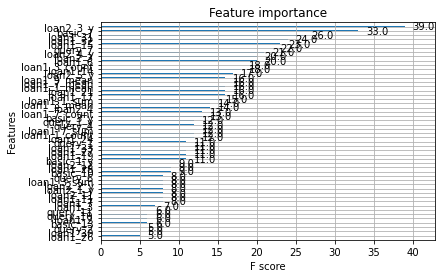

In [50]:
pic=xgb.plot_importance(best_bst,max_num_features=50)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [51]:
important_x

['loan2_3_y',
 'basic_7',
 'loan1_31',
 'loan1_32',
 'loan1_15',
 'query_7',
 'loan2_4_y',
 'loan2_3',
 'loan1_6',
 'loan1_3_count',
 'loan1_14',
 'loan2_5_y',
 'loan1_9_mean',
 'loan1_7_mean',
 'loan1_1_mean',
 'loan1_21',
 'loan1_17',
 'loan1_1_sum',
 'loan1_3_mean',
 'loan2_4',
 'loan1_7_count',
 'basic_3_y',
 'query_1_y',
 'query_4',
 'loan1_7_sum',
 'loan1_1_count',
 'loan1_24',
 'query_1',
 'loan1_33',
 'loan1_27',
 'loan1_19',
 'basic_1_y',
 'loan2_12',
 'loan1_28',
 'basic_10',
 'query_6',
 'loan1_3_sum',
 'loan2_2_y',
 'loan2_1_y',
 'loan2_11',
 'loan1_11',
 'loan1_7',
 'loan1_3',
 'query_11',
 'query_10',
 'loan1_2',
 'basic_13',
 'query_2',
 'loan1_30',
 'loan1_26']

In [52]:
#pd.value_counts(important_x_seq)

* basic_7:年龄
* 

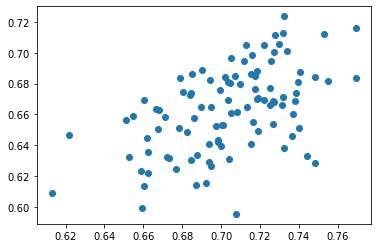

In [53]:
import matplotlib.pyplot as plt
plt.scatter(info_df['local_test_auc'],info_df['test_auc'])

# 输出模块

In [54]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 100
    n=min(N,n)

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后AUC为",max_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


0 0.769451435150917
1 0.7788469446500533
2 0.7756986594292294
3 0.7755012747758862
4 0.7830380787893741
5 0.7831696685582695
6 0.7845020149683363
7 0.7840085533349781
8 0.7841697508018752
9 0.7864495435479891
10 0.787920059215396
11 0.7869989308331277
12 0.7869627436466814
13 0.7864594127806563
14 0.7851731227897032
15 0.7814557118184062
16 0.7807714450201497
17 0.7803766757134633
18 0.7807878937412617
19 0.7808898758121556
20 0.7813932066781808
21 0.7794226498889711
22 0.7798355127888806
23 0.7798470268936589
24 0.78017929106012
25 0.7803174603174603
26 0.780587219343696
27 0.78075828604326
28 0.78017929106012
29 0.7788633933711654
30 0.7788107574636072
31 0.7793305370507443
32 0.780060860268114
33 0.7802220577350112
34 0.7794193601447488
35 0.7793042190969652
36 0.7793601447487457
37 0.7791726293280697
38 0.7779981906406777
39 0.7780804342462374
40 0.7781922855497986
41 0.7783699317378074
42 0.7772119417715273
43 0.7769750801875154
44 0.7761690928530307
45 0.7769356032568467
46 0.777

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用